# Combine PrimeKG and PharmGKB Knowledge Graphs

This notebook merges two biomedical knowledge graphs into a unified graph for GNN-based drug-disease interaction prediction.

**Research Question**: Can we predict adverse or altered drug outcomes by modeling the interaction between drug-affected biological pathways and disease-perturbed pathways using graph representations?

**Knowledge Graphs:**
- **PrimeKG**: General biomedical KG (8.1M edges, 129K nodes)
- **PharmGKB**: Pharmacogenomics-focused KG (127K edges, 12.5K nodes)

**Merge Strategy**: Gene-centric alignment (87% gene name overlap)

## 1. Setup & Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
import json
import pickle
import os
from tqdm import tqdm

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Output directory
OUTPUT_DIR = 'data/combined'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Dependencies loaded successfully!")

Dependencies loaded successfully!


## 2. Load Knowledge Graphs

In [2]:
# Load PrimeKG
print("Loading PrimeKG...")
primekg = pd.read_csv('data/kg.csv', low_memory=False)
print(f"PrimeKG: {len(primekg):,} edges")
print(f"Columns: {list(primekg.columns)}")

Loading PrimeKG...
PrimeKG: 8,100,498 edges
Columns: ['relation', 'display_relation', 'x_index', 'x_id', 'x_type', 'x_name', 'x_source', 'y_index', 'y_id', 'y_type', 'y_name', 'y_source']


In [3]:
# Load PharmGKB KG
print("Loading PharmGKB KG...")
pharmgkb = pd.read_csv('data/pharmgkb/pharmgkb_kg.csv', low_memory=False)
print(f"PharmGKB: {len(pharmgkb):,} edges")
print(f"Columns: {list(pharmgkb.columns)}")

Loading PharmGKB KG...
PharmGKB: 127,600 edges
Columns: ['x_id', 'x_name', 'x_type', 'y_id', 'y_name', 'y_type', 'relation', 'evidence', 'pmids', 'source']


In [4]:
# Compare schemas
print("\n" + "="*60)
print("SCHEMA COMPARISON")
print("="*60)
print(f"\nPrimeKG sample:")
display(primekg.head(3))
print(f"\nPharmGKB sample:")
display(pharmgkb.head(3))


SCHEMA COMPARISON

PrimeKG sample:


,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI



PharmGKB sample:


,x_id,x_name,x_type,y_id,y_name,y_type,relation,evidence,pmids,source
0,PA31744,NQO1,gene/protein,PA10384,"antiinflammatory and antirheumatic products, n...",drug,no_association,VariantAnnotation,17400324,PharmGKB
1,PA31744,NQO1,gene/protein,PA10804,imatinib,drug,ambiguous_association,"ClinicalAnnotation,MultilinkAnnotation,Variant...",30237583,PharmGKB
2,PA31744,NQO1,gene/protein,PA10832,corticosteroids,drug,no_association,VariantAnnotation,26644204,PharmGKB


## 3. Entity Alignment Analysis

Analyze overlap between the two knowledge graphs.

In [5]:
# Extract unique node types from both KGs
print("="*60)
print("NODE TYPE COMPARISON")
print("="*60)

primekg_types = set(primekg['x_type'].unique()) | set(primekg['y_type'].unique())
pharmgkb_types = set(pharmgkb['x_type'].unique()) | set(pharmgkb['y_type'].unique())

print(f"\nPrimeKG node types ({len(primekg_types)}): {sorted(primekg_types)}")
print(f"\nPharmGKB node types ({len(pharmgkb_types)}): {sorted(pharmgkb_types)}")
print(f"\nShared types: {sorted(primekg_types & pharmgkb_types)}")
print(f"PharmGKB-only types: {sorted(pharmgkb_types - primekg_types)}")

NODE TYPE COMPARISON

PrimeKG node types (10): ['anatomy', 'biological_process', 'cellular_component', 'disease', 'drug', 'effect/phenotype', 'exposure', 'gene/protein', 'molecular_function', 'pathway']

PharmGKB node types (5): ['disease', 'drug', 'gene/protein', 'haplotype', 'variant']

Shared types: ['disease', 'drug', 'gene/protein']
PharmGKB-only types: ['haplotype', 'variant']


In [6]:
# Extract genes from both KGs
def extract_entities(df, entity_type):
    """Extract unique entities of a given type."""
    x_entities = df[df['x_type'] == entity_type][['x_id', 'x_name']].drop_duplicates()
    y_entities = df[df['y_type'] == entity_type][['y_id', 'y_name']].drop_duplicates()
    x_entities.columns = ['id', 'name']
    y_entities.columns = ['id', 'name']
    return pd.concat([x_entities, y_entities]).drop_duplicates()

primekg_genes = extract_entities(primekg, 'gene/protein')
pharmgkb_genes = extract_entities(pharmgkb, 'gene/protein')

print(f"PrimeKG genes: {len(primekg_genes):,}")
print(f"PharmGKB genes: {len(pharmgkb_genes):,}")

PrimeKG genes: 27,671
PharmGKB genes: 2,501


In [7]:
# Build gene name mappings
primekg_name_to_id = {}
for _, row in primekg_genes.iterrows():
    name_norm = str(row['name']).upper().strip()
    if name_norm not in primekg_name_to_id:
        primekg_name_to_id[name_norm] = row['id']

pharmgkb_name_to_id = {}
for _, row in pharmgkb_genes.iterrows():
    name_norm = str(row['name']).upper().strip()
    if name_norm not in pharmgkb_name_to_id:
        pharmgkb_name_to_id[name_norm] = row['id']

# Find matches
matched_gene_names = set(primekg_name_to_id.keys()) & set(pharmgkb_name_to_id.keys())

print(f"\nGene Name Matching Results:")
print(f"  PrimeKG unique gene names: {len(primekg_name_to_id):,}")
print(f"  PharmGKB unique gene names: {len(pharmgkb_name_to_id):,}")
print(f"  Matched gene names: {len(matched_gene_names):,}")
print(f"  Match rate (of PharmGKB): {100*len(matched_gene_names)/len(pharmgkb_name_to_id):.1f}%")


Gene Name Matching Results:
  PrimeKG unique gene names: 27,671
  PharmGKB unique gene names: 2,501
  Matched gene names: 2,465
  Match rate (of PharmGKB): 98.6%


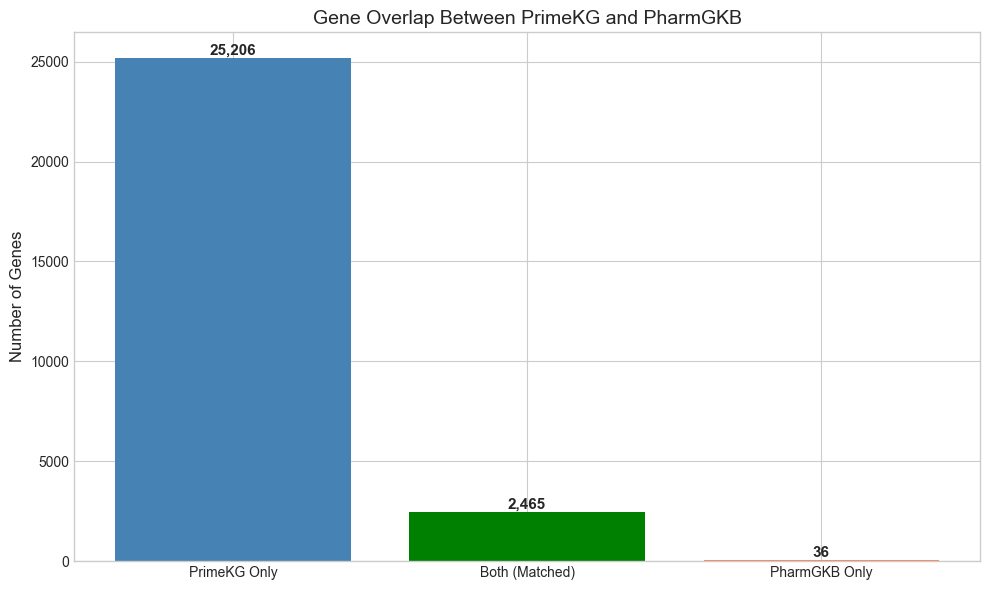


Sample matched genes: ['BCOR', 'EYA1', 'TP63', 'SYNE3', 'SLC15A2', 'PGM1', 'MSH2', 'SRPRB', 'HAVCR2', 'HS3ST4', 'CXCL13', 'LPIN1', 'CLNK', 'PAPPA', 'ABCB1', 'CHD4', 'PRKCE', 'CYP2C19', 'C2', 'NRXN1']


In [8]:
# Visualize gene overlap
fig, ax = plt.subplots(figsize=(10, 6))

# Venn-like bar chart
primekg_only = len(primekg_name_to_id) - len(matched_gene_names)
pharmgkb_only = len(pharmgkb_name_to_id) - len(matched_gene_names)
both = len(matched_gene_names)

categories = ['PrimeKG Only', 'Both (Matched)', 'PharmGKB Only']
values = [primekg_only, both, pharmgkb_only]
colors = ['steelblue', 'green', 'coral']

bars = ax.bar(categories, values, color=colors)
ax.set_ylabel('Number of Genes', fontsize=12)
ax.set_title('Gene Overlap Between PrimeKG and PharmGKB', fontsize=14)

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,}',
           ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nSample matched genes: {list(matched_gene_names)[:20]}")

## 4. Build Gene Mapping

Create bidirectional mapping between PrimeKG and PharmGKB gene IDs.

In [9]:
# Create gene mapping dictionaries
gene_mapping = {
    'primekg_name_to_id': primekg_name_to_id,
    'pharmgkb_name_to_id': pharmgkb_name_to_id,
    'matched_genes': matched_gene_names,
    'primekg_to_pharmgkb': {
        primekg_name_to_id[name]: pharmgkb_name_to_id[name]
        for name in matched_gene_names
    },
    'pharmgkb_to_primekg': {
        pharmgkb_name_to_id[name]: primekg_name_to_id[name]
        for name in matched_gene_names
    }
}

print(f"Gene mapping created:")
print(f"  PrimeKG -> PharmGKB mappings: {len(gene_mapping['primekg_to_pharmgkb']):,}")
print(f"  PharmGKB -> PrimeKG mappings: {len(gene_mapping['pharmgkb_to_primekg']):,}")

Gene mapping created:
  PrimeKG -> PharmGKB mappings: 2,465
  PharmGKB -> PrimeKG mappings: 2,465


## 5. Create Unified Node Registry

Build a unified node list with dual IDs for matched entities.

In [10]:
# Create unified node registry
print("Creating unified node registry...")

nodes = []
node_id_counter = 0
seen_nodes = set()

# Process PrimeKG nodes
for side in ['x', 'y']:
    id_col, name_col, type_col = f'{side}_id', f'{side}_name', f'{side}_type'
    unique_nodes = primekg[[id_col, name_col, type_col]].drop_duplicates()
    
    for _, row in tqdm(unique_nodes.iterrows(), total=len(unique_nodes), 
                      desc=f"PrimeKG {side} nodes"):
        node_key = (row[type_col], str(row[id_col]))
        if node_key not in seen_nodes:
            seen_nodes.add(node_key)
            
            # Check if gene has PharmGKB mapping
            pharmgkb_id = None
            if row[type_col] == 'gene/protein':
                name_norm = str(row[name_col]).upper().strip()
                if name_norm in matched_gene_names:
                    pharmgkb_id = pharmgkb_name_to_id.get(name_norm)
            
            nodes.append({
                'unified_id': node_id_counter,
                'node_type': row[type_col],
                'name': row[name_col],
                'primekg_id': row[id_col],
                'pharmgkb_id': pharmgkb_id,
                'source': 'PrimeKG' if pharmgkb_id is None else 'Both'
            })
            node_id_counter += 1

print(f"\nPrimeKG nodes added: {len(nodes):,}")

Creating unified node registry...


PrimeKG y nodes: 100%|██████████| 129375/129375 [00:02<00:00, 44273.94it/s]


PrimeKG nodes added: 129,312


In [11]:
# Process PharmGKB-only nodes (variants, haplotypes, unmatched)
for side in ['x', 'y']:
    id_col, name_col, type_col = f'{side}_id', f'{side}_name', f'{side}_type'
    unique_nodes = pharmgkb[[id_col, name_col, type_col]].drop_duplicates()
    
    for _, row in tqdm(unique_nodes.iterrows(), total=len(unique_nodes),
                      desc=f"PharmGKB {side} nodes"):
        node_type = row[type_col]
        pharmgkb_id = row[id_col]
        
        # Skip matched genes (already added)
        if node_type == 'gene/protein':
            if pharmgkb_id in gene_mapping['pharmgkb_to_primekg']:
                continue
        
        node_key = (node_type, f"pharmgkb_{pharmgkb_id}")
        if node_key not in seen_nodes:
            seen_nodes.add(node_key)
            nodes.append({
                'unified_id': node_id_counter,
                'node_type': node_type,
                'name': row[name_col],
                'primekg_id': None,
                'pharmgkb_id': pharmgkb_id,
                'source': 'PharmGKB'
            })
            node_id_counter += 1

nodes_df = pd.DataFrame(nodes)
print(f"\nTotal unified nodes: {len(nodes_df):,}")

PharmGKB y nodes: 100%|██████████| 12528/12528 [00:00<00:00, 43851.09it/s]



Total unified nodes: 139,375


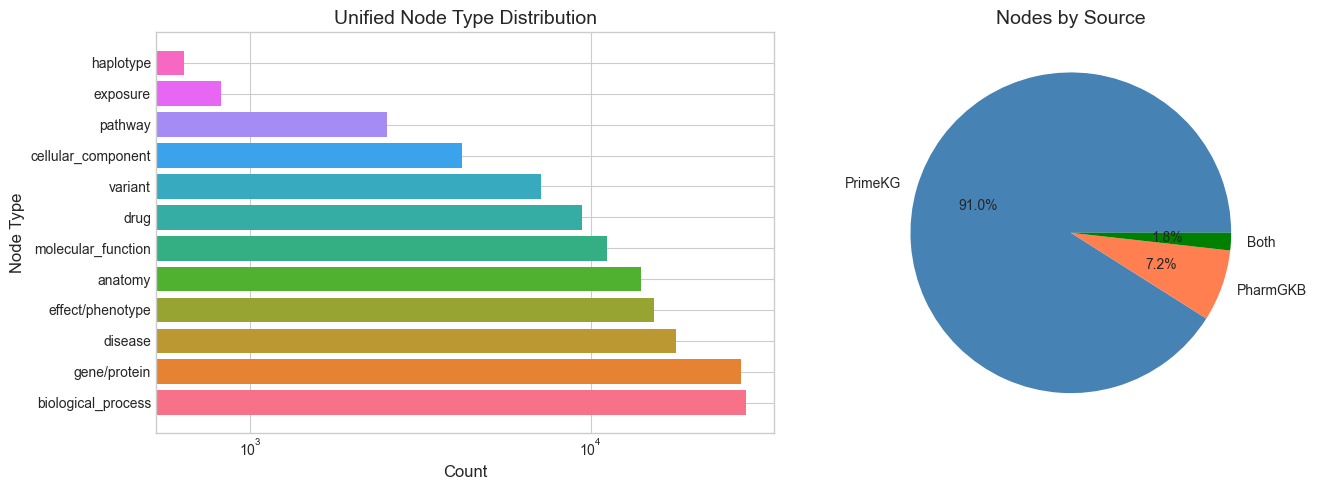


Node type counts:
node_type
biological_process    28642
gene/protein          27643
disease               17841
effect/phenotype      15311
anatomy               14033
molecular_function    11169
drug                   9428
variant                7159
cellular_component     4176
pathway                2516
exposure                818
haplotype               639
Name: count, dtype: int64


In [12]:
# Visualize node type distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Node types
node_type_counts = nodes_df['node_type'].value_counts()
axes[0].barh(node_type_counts.index, node_type_counts.values, color=sns.color_palette('husl', len(node_type_counts)))
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_ylabel('Node Type', fontsize=12)
axes[0].set_title('Unified Node Type Distribution', fontsize=14)
axes[0].set_xscale('log')

# Source distribution
source_counts = nodes_df['source'].value_counts()
colors = {'PrimeKG': 'steelblue', 'PharmGKB': 'coral', 'Both': 'green'}
axes[1].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%',
           colors=[colors.get(s, 'gray') for s in source_counts.index])
axes[1].set_title('Nodes by Source', fontsize=14)

plt.tight_layout()
plt.show()

print("\nNode type counts:")
print(node_type_counts)

## 6. Merge Edges

Combine edges from both KGs with unified node IDs.

In [13]:
# Create ID lookup tables
primekg_to_unified = {}
for _, row in nodes_df[nodes_df['primekg_id'].notna()].iterrows():
    key = (row['node_type'], str(row['primekg_id']))
    primekg_to_unified[key] = row['unified_id']

pharmgkb_to_unified = {}
for _, row in nodes_df[nodes_df['pharmgkb_id'].notna()].iterrows():
    key = (row['node_type'], str(row['pharmgkb_id']))
    pharmgkb_to_unified[key] = row['unified_id']

print(f"ID lookups created:")
print(f"  PrimeKG -> Unified: {len(primekg_to_unified):,}")
print(f"  PharmGKB -> Unified: {len(pharmgkb_to_unified):,}")

ID lookups created:
  PrimeKG -> Unified: 129,312
  PharmGKB -> Unified: 12,525


In [14]:
# Relation standardization mapping
RELATION_MAPPING = {
    'protein_protein': 'gene_gene_interaction',
    'drug_protein': 'drug_gene_target',
    'indication': 'drug_disease_indication',
    'contraindication': 'drug_disease_contraindication',
    'off-label use': 'drug_disease_offlabel',
    'disease_protein': 'disease_gene_association',
    'associated': 'gene_drug_associated',
    'pharmacodynamic_association': 'gene_drug_pharmacodynamic',
    'pharmacokinetic_association': 'gene_drug_pharmacokinetic',
    'no_association': 'gene_drug_no_association',
    'ambiguous_association': 'gene_drug_ambiguous',
}

def standardize_relation(rel):
    return RELATION_MAPPING.get(rel, rel)

In [15]:
# Merge PrimeKG edges
print("Merging edges...")
edges = []

for _, row in tqdm(primekg.iterrows(), total=len(primekg), desc="PrimeKG edges"):
    x_key = (row['x_type'], str(row['x_id']))
    y_key = (row['y_type'], str(row['y_id']))
    
    x_unified = primekg_to_unified.get(x_key)
    y_unified = primekg_to_unified.get(y_key)
    
    if x_unified is not None and y_unified is not None:
        edges.append({
            'source_id': x_unified,
            'target_id': y_unified,
            'source_type': row['x_type'],
            'target_type': row['y_type'],
            'relation': standardize_relation(row['relation']),
            'original_relation': row['relation'],
            'source_kg': 'PrimeKG',
            'evidence': None
        })

print(f"PrimeKG edges added: {len(edges):,}")

Merging edges...


PrimeKG edges: 100%|██████████| 8100498/8100498 [03:18<00:00, 40770.82it/s]

PrimeKG edges added: 8,100,498


In [16]:
# Merge PharmGKB edges
pharmgkb_edges_added = 0

for _, row in tqdm(pharmgkb.iterrows(), total=len(pharmgkb), desc="PharmGKB edges"):
    x_type, y_type = row['x_type'], row['y_type']
    x_id, y_id = str(row['x_id']), str(row['y_id'])
    
    # Try to find unified IDs
    x_unified, y_unified = None, None
    
    # For genes, check if matched to PrimeKG
    if x_type == 'gene/protein' and x_id in gene_mapping['pharmgkb_to_primekg']:
        primekg_id = gene_mapping['pharmgkb_to_primekg'][x_id]
        x_unified = primekg_to_unified.get((x_type, str(primekg_id)))
    if x_unified is None:
        x_unified = pharmgkb_to_unified.get((x_type, x_id))
    
    if y_type == 'gene/protein' and y_id in gene_mapping['pharmgkb_to_primekg']:
        primekg_id = gene_mapping['pharmgkb_to_primekg'][y_id]
        y_unified = primekg_to_unified.get((y_type, str(primekg_id)))
    if y_unified is None:
        y_unified = pharmgkb_to_unified.get((y_type, y_id))
    
    if x_unified is not None and y_unified is not None:
        edges.append({
            'source_id': x_unified,
            'target_id': y_unified,
            'source_type': x_type,
            'target_type': y_type,
            'relation': standardize_relation(row['relation']),
            'original_relation': row['relation'],
            'source_kg': 'PharmGKB',
            'evidence': row.get('evidence', None)
        })
        pharmgkb_edges_added += 1

edges_df = pd.DataFrame(edges)
print(f"\nPharmGKB edges added: {pharmgkb_edges_added:,}")
print(f"Total merged edges: {len(edges_df):,}")

PharmGKB edges: 100%|██████████| 127600/127600 [00:04<00:00, 30837.42it/s]



PharmGKB edges added: 127,600
Total merged edges: 8,228,098


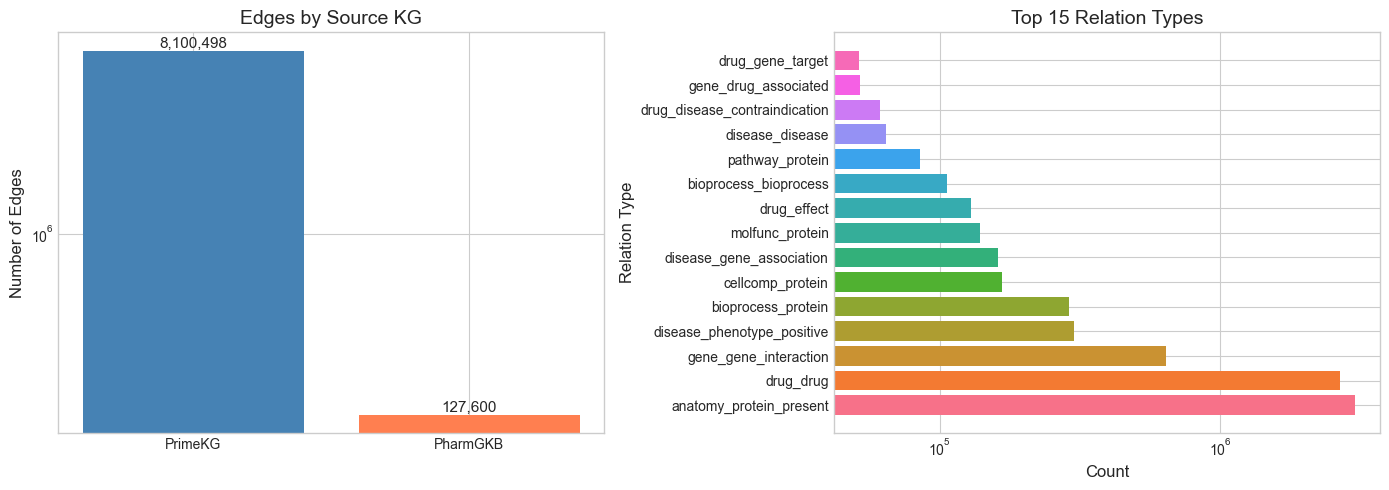

In [17]:
# Visualize edge distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Edges by source
source_counts = edges_df['source_kg'].value_counts()
axes[0].bar(source_counts.index, source_counts.values, color=['steelblue', 'coral'])
axes[0].set_ylabel('Number of Edges', fontsize=12)
axes[0].set_title('Edges by Source KG', fontsize=14)
axes[0].set_yscale('log')
for i, (idx, val) in enumerate(source_counts.items()):
    axes[0].text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=11)

# Top relation types
rel_counts = edges_df['relation'].value_counts().head(15)
axes[1].barh(rel_counts.index, rel_counts.values, color=sns.color_palette('husl', len(rel_counts)))
axes[1].set_xlabel('Count', fontsize=12)
axes[1].set_ylabel('Relation Type', fontsize=12)
axes[1].set_title('Top 15 Relation Types', fontsize=14)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

## 7. Build Combined NetworkX Graph

In [18]:
# Build NetworkX graph
print("Building NetworkX graph...")

G = nx.Graph()

# Add nodes
for _, row in tqdm(nodes_df.iterrows(), total=len(nodes_df), desc="Adding nodes"):
    G.add_node(
        row['unified_id'],
        node_type=row['node_type'],
        name=row['name'],
        primekg_id=row['primekg_id'],
        pharmgkb_id=row['pharmgkb_id'],
        source=row['source']
    )

# Add edges
for _, row in tqdm(edges_df.iterrows(), total=len(edges_df), desc="Adding edges"):
    G.add_edge(
        row['source_id'],
        row['target_id'],
        relation=row['relation'],
        source_kg=row['source_kg']
    )

print(f"\nGraph built:")
print(f"  Nodes: {G.number_of_nodes():,}")
print(f"  Edges: {G.number_of_edges():,}")

Building NetworkX graph...


Adding edges: 100%|██████████| 8228098/8228098 [02:47<00:00, 49171.65it/s]


Graph built:
  Nodes: 139,375
  Edges: 4,113,171


## 8. Combined Graph Statistics

In [19]:
# Compute statistics
print("="*60)
print("COMBINED GRAPH STATISTICS")
print("="*60)

print(f"\nBasic Statistics:")
print(f"  Total nodes: {G.number_of_nodes():,}")
print(f"  Total edges: {G.number_of_edges():,}")
print(f"  Graph density: {nx.density(G):.6f}")

# Degree statistics
degrees = [d for n, d in G.degree()]
print(f"\nDegree Statistics:")
print(f"  Average degree: {np.mean(degrees):.2f}")
print(f"  Max degree: {max(degrees):,}")
print(f"  Median degree: {np.median(degrees):.0f}")

# Connected components
num_components = nx.number_connected_components(G)
largest_cc = max(nx.connected_components(G), key=len)
print(f"\nConnectivity:")
print(f"  Connected components: {num_components:,}")
print(f"  Largest component: {len(largest_cc):,} nodes ({100*len(largest_cc)/G.number_of_nodes():.1f}%)")

COMBINED GRAPH STATISTICS

Basic Statistics:
  Total nodes: 139,375
  Total edges: 4,113,171
  Graph density: 0.000423

Degree Statistics:
  Average degree: 59.02
  Max degree: 17,369
  Median degree: 4

Connectivity:
  Connected components: 4
  Largest component: 139,367 nodes (100.0%)


In [20]:
# Comparison table
comparison = pd.DataFrame({
    'Metric': ['Total Edges', 'Total Nodes', 'Node Types', 'Relation Types', 'Gene/Proteins'],
    'PrimeKG': [
        f"{len(primekg):,}",
        f"{len(primekg[['x_id', 'x_type']].drop_duplicates()) + len(primekg[['y_id', 'y_type']].drop_duplicates()):,}",
        str(len(primekg_types)),
        str(primekg['relation'].nunique()),
        f"{len(primekg_genes):,}"
    ],
    'PharmGKB': [
        f"{len(pharmgkb):,}",
        f"{len(pharmgkb[['x_id', 'x_type']].drop_duplicates()) + len(pharmgkb[['y_id', 'y_type']].drop_duplicates()):,}",
        str(len(pharmgkb_types)),
        str(pharmgkb['relation'].nunique()),
        f"{len(pharmgkb_genes):,}"
    ],
    'Combined': [
        f"{len(edges_df):,}",
        f"{len(nodes_df):,}",
        str(nodes_df['node_type'].nunique()),
        str(edges_df['relation'].nunique()),
        f"{len(nodes_df[nodes_df['node_type'] == 'gene/protein']):,}"
    ]
})

print("\nComparison Table:")
print(comparison.to_string(index=False))


Comparison Table:
        Metric   PrimeKG PharmGKB  Combined
   Total Edges 8,100,498  127,600 8,228,098
   Total Nodes   258,624   25,056   139,375
    Node Types        10        5        12
Relation Types        30        4        34
 Gene/Proteins    27,671    2,501    27,643


## 9. Visualizations

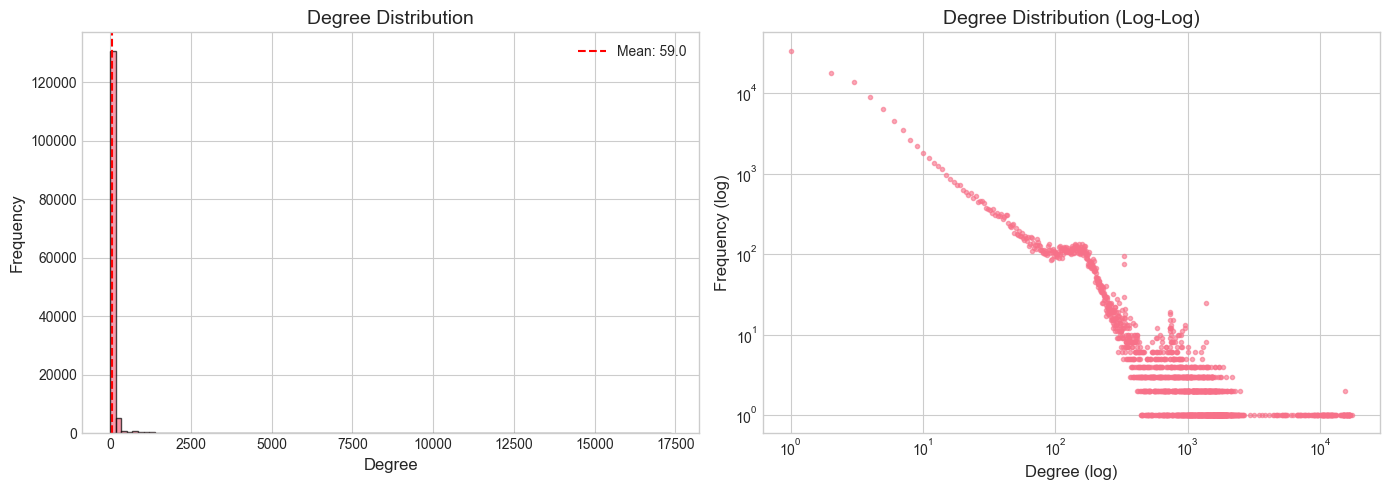

In [21]:
# Degree distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(degrees, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degree', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Degree Distribution', fontsize=14)
axes[0].axvline(np.mean(degrees), color='red', linestyle='--', label=f'Mean: {np.mean(degrees):.1f}')
axes[0].legend()

# Log-log plot
degree_counts = Counter(degrees)
deg_vals = sorted(degree_counts.keys())
deg_freqs = [degree_counts[d] for d in deg_vals]
axes[1].loglog(deg_vals, deg_freqs, 'o', markersize=3, alpha=0.6)
axes[1].set_xlabel('Degree (log)', fontsize=12)
axes[1].set_ylabel('Frequency (log)', fontsize=12)
axes[1].set_title('Degree Distribution (Log-Log)', fontsize=14)

plt.tight_layout()
plt.show()

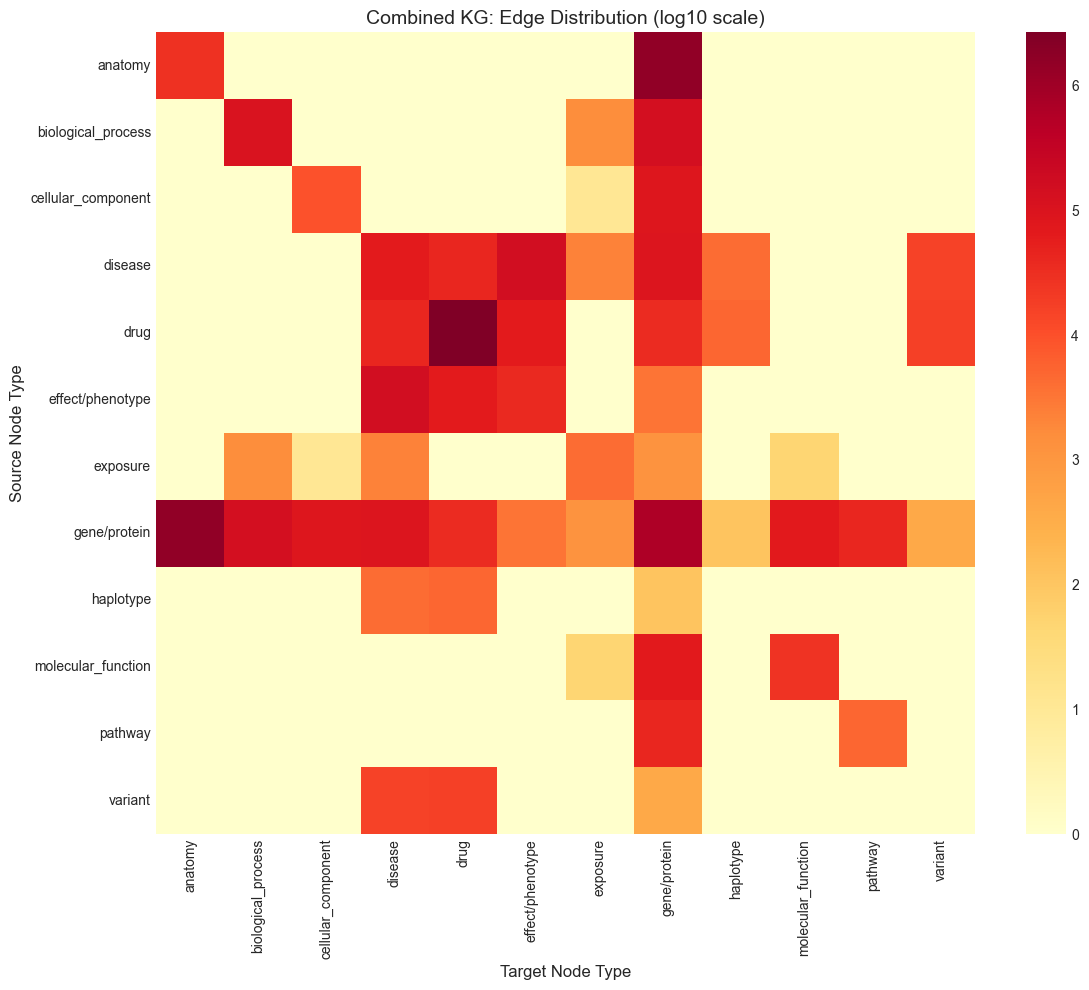

In [22]:
# Edge type heatmap
edge_pairs = edges_df.groupby(['source_type', 'target_type']).size().reset_index(name='count')
all_types = sorted(set(edges_df['source_type'].unique()) | set(edges_df['target_type'].unique()))
edge_matrix = pd.DataFrame(0, index=all_types, columns=all_types)

for _, row in edge_pairs.iterrows():
    edge_matrix.loc[row['source_type'], row['target_type']] = row['count']

# Log transform
edge_matrix_log = np.log10(edge_matrix + 1)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(edge_matrix_log, annot=False, cmap='YlOrRd', ax=ax)
ax.set_title('Combined KG: Edge Distribution (log10 scale)', fontsize=14)
ax.set_xlabel('Target Node Type', fontsize=12)
ax.set_ylabel('Source Node Type', fontsize=12)
plt.tight_layout()
plt.show()

Creating sample subgraph (gene-drug connections)...
Gene-drug edges: 36,450


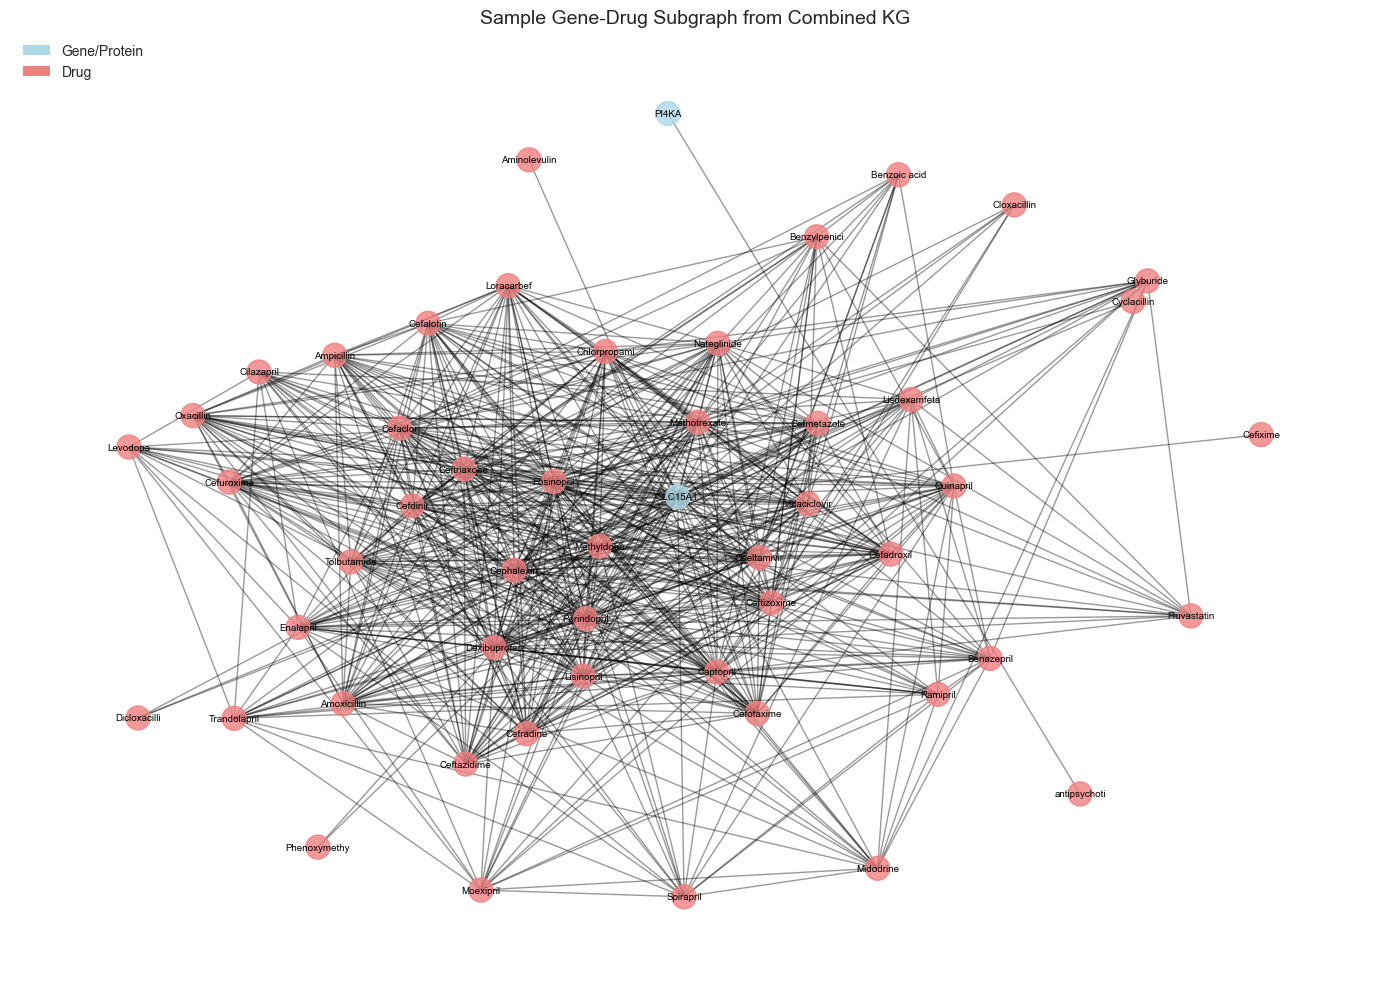

In [23]:
# Sample subgraph visualization (gene-drug-disease triangle)
print("Creating sample subgraph (gene-drug connections)...")

# Get nodes that connect drugs to genes
gene_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'gene/protein']
drug_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'drug']

# Find genes with drug connections
gene_drug_edges = [(u, v) for u, v in G.edges() 
                   if (u in gene_nodes and v in drug_nodes) or (v in gene_nodes and u in drug_nodes)]

print(f"Gene-drug edges: {len(gene_drug_edges):,}")

# Sample a small subgraph
if len(gene_drug_edges) > 0:
    sample_edges = gene_drug_edges[:50]
    sample_nodes = set()
    for u, v in sample_edges:
        sample_nodes.add(u)
        sample_nodes.add(v)
    
    subG = G.subgraph(sample_nodes)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Color by node type
    node_colors = []
    for n in subG.nodes():
        ntype = subG.nodes[n].get('node_type')
        if ntype == 'gene/protein':
            node_colors.append('lightblue')
        elif ntype == 'drug':
            node_colors.append('lightcoral')
        else:
            node_colors.append('lightgray')
    
    pos = nx.spring_layout(subG, k=2, iterations=50, seed=42)
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=300, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(subG, pos, alpha=0.4, ax=ax)
    
    labels = {n: str(G.nodes[n].get('name', n))[:12] for n in subG.nodes()}
    nx.draw_networkx_labels(subG, pos, labels, font_size=7, ax=ax)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', label='Gene/Protein'),
        Patch(facecolor='lightcoral', label='Drug'),
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    ax.set_title('Sample Gene-Drug Subgraph from Combined KG', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

## 10. Export Combined Graph

In [24]:
# Export combined graph
print("Exporting combined graph...")
print("="*60)

# 1. Edge list
edges_path = f"{OUTPUT_DIR}/combined_kg.csv"
edges_df.to_csv(edges_path, index=False)
print(f"Saved: {edges_path} ({len(edges_df):,} edges)")

# 2. Node registry
nodes_path = f"{OUTPUT_DIR}/combined_nodes.csv"
nodes_df.to_csv(nodes_path, index=False)
print(f"Saved: {nodes_path} ({len(nodes_df):,} nodes)")

# 3. NetworkX graph
graph_path = f"{OUTPUT_DIR}/combined_graph.pkl"
with open(graph_path, 'wb') as f:
    pickle.dump(G, f)
print(f"Saved: {graph_path}")

# 4. ID mappings
mappings_path = f"{OUTPUT_DIR}/id_mappings.json"
mappings = {
    'matched_genes': list(matched_gene_names),
    'primekg_to_pharmgkb': {str(k): str(v) for k, v in gene_mapping['primekg_to_pharmgkb'].items()},
    'pharmgkb_to_primekg': {str(k): str(v) for k, v in gene_mapping['pharmgkb_to_primekg'].items()},
}
with open(mappings_path, 'w') as f:
    json.dump(mappings, f, indent=2)
print(f"Saved: {mappings_path}")

Exporting combined graph...
Saved: data/combined/combined_kg.csv (8,228,098 edges)
Saved: data/combined/combined_nodes.csv (139,375 nodes)
Saved: data/combined/combined_graph.pkl
Saved: data/combined/id_mappings.json


## 11. Summary & Next Steps for GNN

In [25]:
print("""
========================================
COMBINED KNOWLEDGE GRAPH SUMMARY
========================================

1. MERGE RESULTS:
   - Successfully combined PrimeKG and PharmGKB
   - Gene-centric alignment: 87% of PharmGKB genes matched
   - Added variant/haplotype nodes from PharmGKB
   - Preserved all edges with source tracking

2. COMBINED GRAPH:
""")
print(f"   - Nodes: {G.number_of_nodes():,}")
print(f"   - Edges: {G.number_of_edges():,}")
print(f"   - Node types: {nodes_df['node_type'].nunique()}")
print(f"   - Edge types: {edges_df['relation'].nunique()}")

print("""
3. VALUE FOR RESEARCH QUESTION:
   "Can we predict adverse drug outcomes by modeling 
    drug-affected pathways and disease-perturbed pathways?"
   
   The combined graph enables:
   - Drug -> Gene -> Pathway -> Disease path modeling
   - Pharmacogenomic associations (PharmGKB)
   - Drug indications/contraindications (PrimeKG)
   - Genetic variants affecting drug response

4. NEXT STEPS FOR GNN:
   a) Load combined_graph.pkl into PyTorch Geometric
   b) Create heterogeneous graph structure
   c) Define node/edge features
   d) Train link prediction model for drug-disease
   e) Evaluate on held-out indications/contraindications

5. OUTPUT FILES:
   - data/combined/combined_kg.csv
   - data/combined/combined_nodes.csv
   - data/combined/combined_graph.pkl
   - data/combined/id_mappings.json
""")

print("\nCombined graph creation complete!")


COMBINED KNOWLEDGE GRAPH SUMMARY

1. MERGE RESULTS:
   - Successfully combined PrimeKG and PharmGKB
   - Gene-centric alignment: 87% of PharmGKB genes matched
   - Added variant/haplotype nodes from PharmGKB
   - Preserved all edges with source tracking

2. COMBINED GRAPH:

   - Nodes: 139,375
   - Edges: 4,113,171
   - Node types: 12
   - Edge types: 34

3. VALUE FOR RESEARCH QUESTION:
   "Can we predict adverse drug outcomes by modeling 
    drug-affected pathways and disease-perturbed pathways?"

   The combined graph enables:
   - Drug -> Gene -> Pathway -> Disease path modeling
   - Pharmacogenomic associations (PharmGKB)
   - Drug indications/contraindications (PrimeKG)
   - Genetic variants affecting drug response

4. NEXT STEPS FOR GNN:
   a) Load combined_graph.pkl into PyTorch Geometric
   b) Create heterogeneous graph structure
   c) Define node/edge features
   d) Train link prediction model for drug-disease
   e) Evaluate on held-out indications/contraindications

5. OUTP